## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [8]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = (f"optimizer: {optim}, reduce_factor: {reduce_factor}, reduce_patient: {reduce_patient}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
______________________________________________________________

Epoch 11/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3128 - accuracy: 0.5425 - val_loss: 1.5020 - val_accuracy: 0.4727
Epoch 12/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2914 - accuracy: 0.5504 - val_loss: 1.4919 - val_accuracy: 0.4765
Epoch 13/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2677 - accuracy: 0.5572 - val_loss: 1.4811 - val_accuracy: 0.4800
Epoch 14/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2460 - accuracy: 0.5651 - val_loss: 1.4898 - val_accuracy: 0.4748
Epoch 15/25
49/49 [==============================] - 1s 26ms/step - loss: 1.2252 - accuracy: 0.5746 - val_loss: 1.4703 - val_accuracy: 0.4884
Epoch 16/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2061 - accuracy: 0.5789 - val_loss: 1.4737 - val_accuracy: 0.4885
Epoch 17/25
49/49 [==============================] - 1s 25ms/step - loss: 1.1851 - accuracy: 0.5883 - val_loss: 1.4665 - val_accuracy: 0.4921
Epoch 

Epoch 1/25
49/49 [==============================] - 1s 29ms/step - loss: 2.2547 - accuracy: 0.2613 - val_loss: 2.1604 - val_accuracy: 0.1840
Epoch 2/25
49/49 [==============================] - 1s 25ms/step - loss: 1.7745 - accuracy: 0.3838 - val_loss: 1.9916 - val_accuracy: 0.3008
Epoch 3/25
49/49 [==============================] - 1s 25ms/step - loss: 1.6405 - accuracy: 0.4243 - val_loss: 1.8729 - val_accuracy: 0.3389
Epoch 4/25
49/49 [==============================] - 1s 25ms/step - loss: 1.5664 - accuracy: 0.4491 - val_loss: 1.7525 - val_accuracy: 0.3876
Epoch 5/25
49/49 [==============================] - 1s 26ms/step - loss: 1.5131 - accuracy: 0.4671 - val_loss: 1.6630 - val_accuracy: 0.4162
Epoch 6/25
49/49 [==============================] - 1s 25ms/step - loss: 1.4696 - accuracy: 0.4828 - val_loss: 1.6064 - val_accuracy: 0.4320
Epoch 7/25
49/49 [==============================] - 1s 25ms/step - loss: 1.4334 - accuracy: 0.4961 - val_loss: 1.5561 - val_accuracy: 0.4477
Epoch 8/25
49

49/49 [==============================] - 1s 25ms/step - loss: 1.0875 - accuracy: 0.6243 - val_loss: 1.4416 - val_accuracy: 0.4929
Epoch 24/25
49/49 [==============================] - 1s 27ms/step - loss: 1.0702 - accuracy: 0.6332 - val_loss: 1.4478 - val_accuracy: 0.4951
Epoch 25/25
49/49 [==============================] - 1s 25ms/step - loss: 1.0542 - accuracy: 0.6377 - val_loss: 1.4389 - val_accuracy: 0.4982
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
__________________________________________

49/49 [==============================] - 1s 25ms/step - loss: 1.3506 - accuracy: 0.5289 - val_loss: 1.5088 - val_accuracy: 0.4672
Epoch 11/25
49/49 [==============================] - 1s 26ms/step - loss: 1.3237 - accuracy: 0.5392 - val_loss: 1.4941 - val_accuracy: 0.4700
Epoch 12/25
49/49 [==============================] - 1s 26ms/step - loss: 1.2999 - accuracy: 0.5450 - val_loss: 1.4834 - val_accuracy: 0.4729
Epoch 13/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2777 - accuracy: 0.5555 - val_loss: 1.4832 - val_accuracy: 0.4765
Epoch 14/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2566 - accuracy: 0.5616 - val_loss: 1.4670 - val_accuracy: 0.4785
Epoch 15/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2374 - accuracy: 0.5696 - val_loss: 1.4747 - val_accuracy: 0.4728
Epoch 16/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2152 - accuracy: 0.5773 - val_loss: 1.4715 - val_accuracy: 0.4816
Epoch 17/25
49/49 

Epoch 1/25
49/49 [==============================] - 1s 31ms/step - loss: 2.7264 - accuracy: 0.1489 - val_loss: 2.2461 - val_accuracy: 0.1498
Epoch 2/25
49/49 [==============================] - 1s 27ms/step - loss: 2.2929 - accuracy: 0.2391 - val_loss: 2.1807 - val_accuracy: 0.1816
Epoch 3/25
49/49 [==============================] - 1s 27ms/step - loss: 2.1184 - accuracy: 0.2828 - val_loss: 2.0942 - val_accuracy: 0.2300
Epoch 4/25
49/49 [==============================] - 1s 25ms/step - loss: 2.0161 - accuracy: 0.3075 - val_loss: 2.0091 - val_accuracy: 0.2694
Epoch 5/25
49/49 [==============================] - 1s 25ms/step - loss: 1.9481 - accuracy: 0.3298 - val_loss: 1.9370 - val_accuracy: 0.3078
Epoch 6/25
49/49 [==============================] - 1s 26ms/step - loss: 1.8967 - accuracy: 0.3450 - val_loss: 1.8862 - val_accuracy: 0.3319
Epoch 7/25
49/49 [==============================] - 1s 25ms/step - loss: 1.8553 - accuracy: 0.3591 - val_loss: 1.8486 - val_accuracy: 0.3484
Epoch 8/25
49

Epoch 19/25
49/49 [==============================] - 1s 25ms/step - loss: 0.5922 - accuracy: 0.7979 - val_loss: 2.0442 - val_accuracy: 0.4316
Epoch 20/25
48/49 [============================>.] - ETA: 0s - loss: 0.5502 - accuracy: 0.8125
Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0009509901772253215.
49/49 [==============================] - 1s 25ms/step - loss: 0.5515 - accuracy: 0.8117 - val_loss: 2.0919 - val_accuracy: 0.4315
Epoch 21/25
49/49 [==============================] - 1s 25ms/step - loss: 0.5156 - accuracy: 0.8240 - val_loss: 1.9836 - val_accuracy: 0.4416
Epoch 22/25
49/49 [==============================] - 1s 25ms/step - loss: 0.4802 - accuracy: 0.8384 - val_loss: 2.0794 - val_accuracy: 0.4357
Epoch 23/25
49/49 [==============================] - ETA: 0s - loss: 0.4465 - accuracy: 0.8515
Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
49/49 [==============================] - 1s 25ms/step - loss: 0.4465 - accuracy: 0.8515 - val_

49/49 [==============================] - 1s 29ms/step - loss: 1.8203 - accuracy: 0.3621 - val_loss: 5.9098 - val_accuracy: 0.1560
Epoch 2/25
49/49 [==============================] - 1s 25ms/step - loss: 1.5609 - accuracy: 0.4455 - val_loss: 2.2708 - val_accuracy: 0.2859
Epoch 3/25
49/49 [==============================] - 1s 25ms/step - loss: 1.4650 - accuracy: 0.4789 - val_loss: 1.8626 - val_accuracy: 0.3474
Epoch 4/25
49/49 [==============================] - 1s 26ms/step - loss: 1.3949 - accuracy: 0.5051 - val_loss: 1.7910 - val_accuracy: 0.3895
Epoch 5/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3318 - accuracy: 0.5244 - val_loss: 1.4895 - val_accuracy: 0.4732
Epoch 6/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2798 - accuracy: 0.5456 - val_loss: 1.5154 - val_accuracy: 0.4615
Epoch 7/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2292 - accuracy: 0.5641 - val_loss: 1.5135 - val_accuracy: 0.4606
Epoch 8/25
49/49 [======

Epoch 21/25
49/49 [==============================] - 1s 25ms/step - loss: 0.7400 - accuracy: 0.7471 - val_loss: 1.4106 - val_accuracy: 0.5279
Epoch 22/25
49/49 [==============================] - 1s 25ms/step - loss: 0.7191 - accuracy: 0.7562 - val_loss: 1.4129 - val_accuracy: 0.5326
Epoch 23/25
49/49 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.7597
Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00011418967187637463.
49/49 [==============================] - 1s 25ms/step - loss: 0.7076 - accuracy: 0.7597 - val_loss: 1.4130 - val_accuracy: 0.5345
Epoch 24/25
49/49 [==============================] - 1s 25ms/step - loss: 0.6789 - accuracy: 0.7719 - val_loss: 1.4114 - val_accuracy: 0.5371
Epoch 25/25
49/49 [==============================] - 1s 25ms/step - loss: 0.6698 - accuracy: 0.7753 - val_loss: 1.4281 - val_accuracy: 0.5334
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_27"
____________________________________________

49/49 [==============================] - 1s 25ms/step - loss: 1.4890 - accuracy: 0.4793 - val_loss: 1.6785 - val_accuracy: 0.4296
Epoch 5/25
49/49 [==============================] - 1s 25ms/step - loss: 1.4423 - accuracy: 0.4984 - val_loss: 1.6021 - val_accuracy: 0.4454
Epoch 6/25
49/49 [==============================] - 1s 25ms/step - loss: 1.4046 - accuracy: 0.5107 - val_loss: 1.5532 - val_accuracy: 0.4620
Epoch 7/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3715 - accuracy: 0.5220 - val_loss: 1.5332 - val_accuracy: 0.4571
Epoch 8/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3426 - accuracy: 0.5346 - val_loss: 1.5027 - val_accuracy: 0.4730
Epoch 9/25
49/49 [==============================] - 1s 25ms/step - loss: 1.3193 - accuracy: 0.5428 - val_loss: 1.5002 - val_accuracy: 0.4724
Epoch 10/25
49/49 [==============================] - 1s 25ms/step - loss: 1.2959 - accuracy: 0.5505 - val_loss: 1.4781 - val_accuracy: 0.4813
Epoch 11/25
49/49 [====

49/49 [==============================] - 1s 25ms/step - loss: 1.1666 - accuracy: 0.6010 - val_loss: 1.4410 - val_accuracy: 0.4952
Epoch 25/25
49/49 [==============================] - 1s 25ms/step - loss: 1.1670 - accuracy: 0.6007 - val_loss: 1.4411 - val_accuracy: 0.4955
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 5
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_48 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
____________________________________________________

49/49 [==============================] - 1s 26ms/step - loss: 3.0770 - accuracy: 0.0978 - val_loss: 2.6380 - val_accuracy: 0.0928
Epoch 7/25
49/49 [==============================] - 1s 25ms/step - loss: 3.0768 - accuracy: 0.0970 - val_loss: 2.7218 - val_accuracy: 0.0924
Epoch 8/25
49/49 [==============================] - 1s 25ms/step - loss: 3.0770 - accuracy: 0.0972 - val_loss: 2.7992 - val_accuracy: 0.0914
Epoch 9/25
49/49 [==============================] - 1s 26ms/step - loss: 3.0756 - accuracy: 0.0974 - val_loss: 2.8668 - val_accuracy: 0.0926
Epoch 10/25
49/49 [==============================] - 1s 25ms/step - loss: 3.0767 - accuracy: 0.0972 - val_loss: 2.9233 - val_accuracy: 0.0929
Epoch 11/25
49/49 [==============================] - ETA: 0s - loss: 3.0767 - accuracy: 0.0969
Epoch 00011: ReduceLROnPlateau reducing learning rate to 2.8547417901814144e-12.
49/49 [==============================] - 1s 25ms/step - loss: 3.0767 - accuracy: 0.0969 - val_loss: 2.9690 - val_accuracy: 0.0939

Epoch 22/25
49/49 [==============================] - 1s 28ms/step - loss: 0.6374 - accuracy: 0.7801 - val_loss: 1.8748 - val_accuracy: 0.4429
Epoch 23/25
49/49 [==============================] - 1s 28ms/step - loss: 0.6180 - accuracy: 0.7860 - val_loss: 2.0409 - val_accuracy: 0.4254
Epoch 24/25
47/49 [===========================>..] - ETA: 0s - loss: 0.5893 - accuracy: 0.7967
Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009414802846731617.
49/49 [==============================] - 2s 31ms/step - loss: 0.5913 - accuracy: 0.7959 - val_loss: 1.8458 - val_accuracy: 0.4685
Epoch 25/25
49/49 [==============================] - 1s 28ms/step - loss: 0.5599 - accuracy: 0.8077 - val_loss: 1.9095 - val_accuracy: 0.4755
Numbers of exp: 19, reduce_factor: 0.99, reduce_patient: 5
Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 3072)]            

49/49 [==============================] - 1s 29ms/step - loss: 1.2727 - accuracy: 0.5484 - val_loss: 2.2582 - val_accuracy: 0.2966
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 1.2210 - accuracy: 0.5694 - val_loss: 1.9043 - val_accuracy: 0.3754
Epoch 7/25
49/49 [==============================] - 1s 29ms/step - loss: 1.1622 - accuracy: 0.5909 - val_loss: 1.7065 - val_accuracy: 0.4094
Epoch 8/25
49/49 [==============================] - 1s 29ms/step - loss: 1.1267 - accuracy: 0.6030 - val_loss: 1.7456 - val_accuracy: 0.4163
Epoch 9/25
49/49 [==============================] - 1s 29ms/step - loss: 1.0769 - accuracy: 0.6197 - val_loss: 1.7042 - val_accuracy: 0.4131
Epoch 10/25
49/49 [==============================] - 1s 29ms/step - loss: 1.0436 - accuracy: 0.6341 - val_loss: 1.6150 - val_accuracy: 0.4497
Epoch 11/25
49/49 [==============================] - 1s 29ms/step - loss: 1.0029 - accuracy: 0.6468 - val_loss: 1.9933 - val_accuracy: 0.3863
Epoch 12/25
49/49 [===

Epoch 22/25
49/49 [==============================] - 1s 29ms/step - loss: 0.6540 - accuracy: 0.7908 - val_loss: 1.3619 - val_accuracy: 0.5421
Epoch 23/25
47/49 [===========================>..] - ETA: 0s - loss: 0.6472 - accuracy: 0.7928
Epoch 00023: ReduceLROnPlateau reducing learning rate to 2.8547417969093658e-05.
49/49 [==============================] - 1s 28ms/step - loss: 0.6478 - accuracy: 0.7925 - val_loss: 1.3687 - val_accuracy: 0.5393
Epoch 24/25
49/49 [==============================] - 1s 28ms/step - loss: 0.6365 - accuracy: 0.7984 - val_loss: 1.3648 - val_accuracy: 0.5474
Epoch 25/25
49/49 [==============================] - 1s 28ms/step - loss: 0.6335 - accuracy: 0.7993 - val_loss: 1.3697 - val_accuracy: 0.5434
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 3072)]           

Epoch 8/25
49/49 [==============================] - 1s 28ms/step - loss: 1.5373 - accuracy: 0.4614 - val_loss: 1.6375 - val_accuracy: 0.4238
Epoch 9/25
49/49 [==============================] - 1s 28ms/step - loss: 1.5064 - accuracy: 0.4703 - val_loss: 1.6020 - val_accuracy: 0.4404
Epoch 10/25
49/49 [==============================] - 1s 28ms/step - loss: 1.4800 - accuracy: 0.4810 - val_loss: 1.5969 - val_accuracy: 0.4440
Epoch 11/25
49/49 [==============================] - 1s 28ms/step - loss: 1.4541 - accuracy: 0.4905 - val_loss: 1.5859 - val_accuracy: 0.4484
Epoch 12/25
49/49 [==============================] - 1s 28ms/step - loss: 1.4320 - accuracy: 0.4989 - val_loss: 1.5732 - val_accuracy: 0.4489
Epoch 13/25
49/49 [==============================] - 1s 28ms/step - loss: 1.4101 - accuracy: 0.5069 - val_loss: 1.5562 - val_accuracy: 0.4583
Epoch 14/25
49/49 [==============================] - 1s 28ms/step - loss: 1.3902 - accuracy: 0.5154 - val_loss: 1.5536 - val_accuracy: 0.4599
Epoch 15

Epoch 1/25
49/49 [==============================] - 2s 33ms/step - loss: 2.2998 - accuracy: 0.2444 - val_loss: 2.2031 - val_accuracy: 0.1847
Epoch 2/25
49/49 [==============================] - 1s 29ms/step - loss: 1.9590 - accuracy: 0.3331 - val_loss: 2.0973 - val_accuracy: 0.2573
Epoch 3/25
49/49 [==============================] - 1s 29ms/step - loss: 1.8250 - accuracy: 0.3710 - val_loss: 2.0002 - val_accuracy: 0.2905
Epoch 4/25
49/49 [==============================] - 1s 29ms/step - loss: 1.7356 - accuracy: 0.3998 - val_loss: 1.8748 - val_accuracy: 0.3331
Epoch 5/25
49/49 [==============================] - 1s 29ms/step - loss: 1.6703 - accuracy: 0.4206 - val_loss: 1.7685 - val_accuracy: 0.3732
Epoch 6/25
49/49 [==============================] - 1s 29ms/step - loss: 1.6215 - accuracy: 0.4361 - val_loss: 1.7199 - val_accuracy: 0.3887
Epoch 7/25
49/49 [==============================] - 1s 29ms/step - loss: 1.5778 - accuracy: 0.4510 - val_loss: 1.6711 - val_accuracy: 0.4065
Epoch 8/25
49

49/49 [==============================] - 1s 28ms/step - loss: 1.2324 - accuracy: 0.5740 - val_loss: 1.5063 - val_accuracy: 0.4720
Epoch 24/25
49/49 [==============================] - 1s 27ms/step - loss: 1.2214 - accuracy: 0.5804 - val_loss: 1.5093 - val_accuracy: 0.4692
Epoch 25/25
49/49 [==============================] - 1s 27ms/step - loss: 1.2085 - accuracy: 0.5851 - val_loss: 1.4996 - val_accuracy: 0.4720


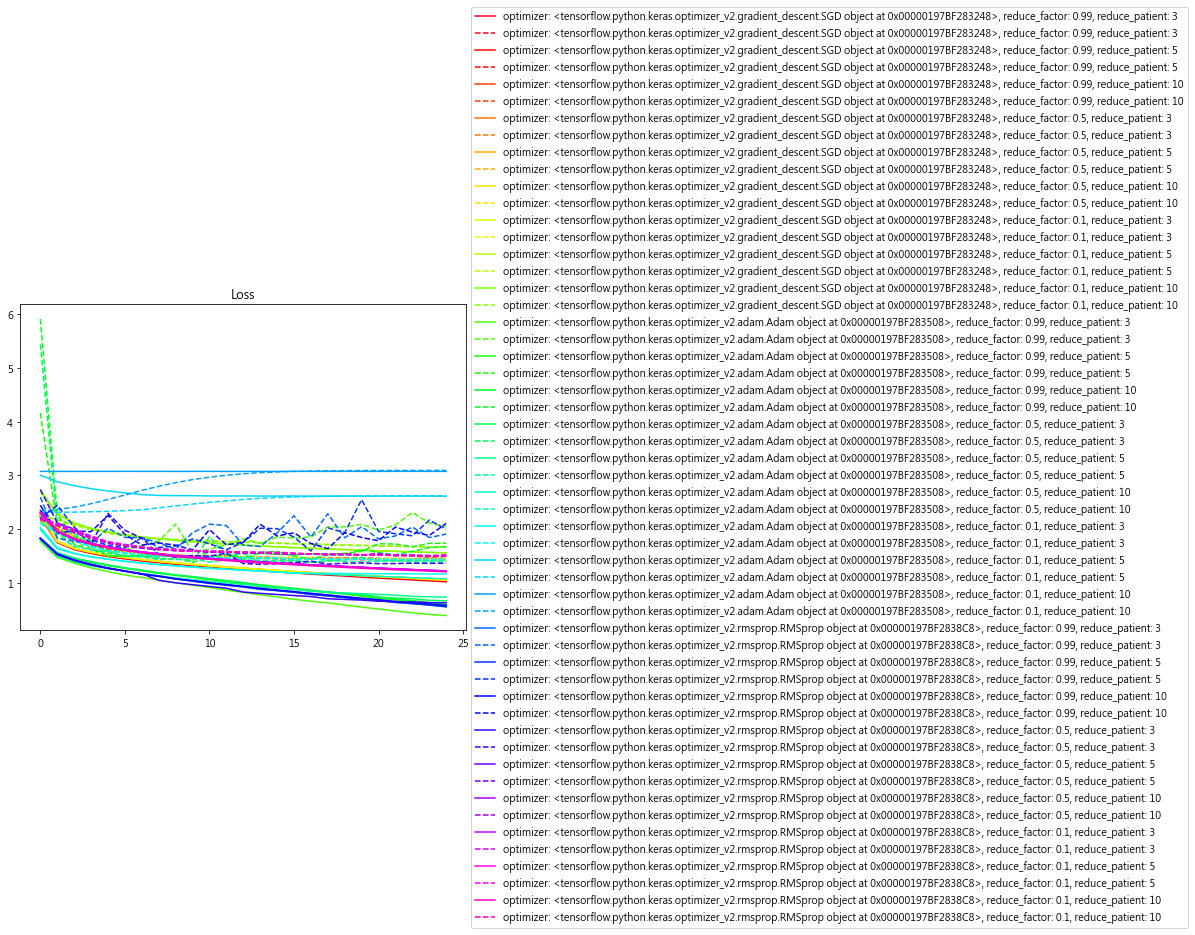

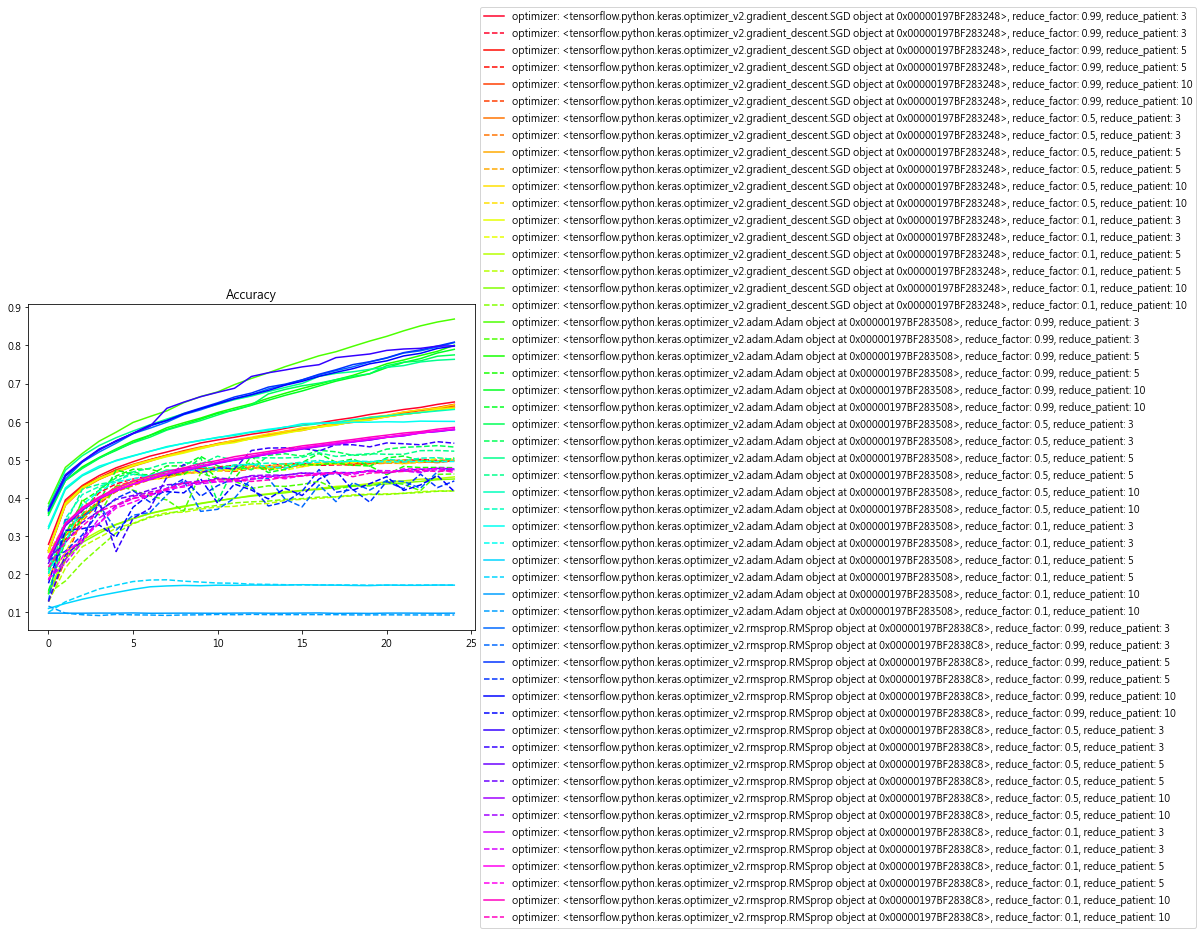

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()